# Import necessary libraries

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Normalization

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pickle
import joblib
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
clear_output()

# Data preprocessing

In [41]:
df = pd.read_csv('/home/khangpt/MUSIC-GEN-PROJ/music_crawler/Dataset.csv')
def preprocess_(df):
    X = df.drop(['label'], axis = 1)
    y = df['label']

    df.label = pd.Categorical(df.label)
    y = np.array(df.label.cat.codes)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X, y
X, y = preprocess_(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Config the Keras model

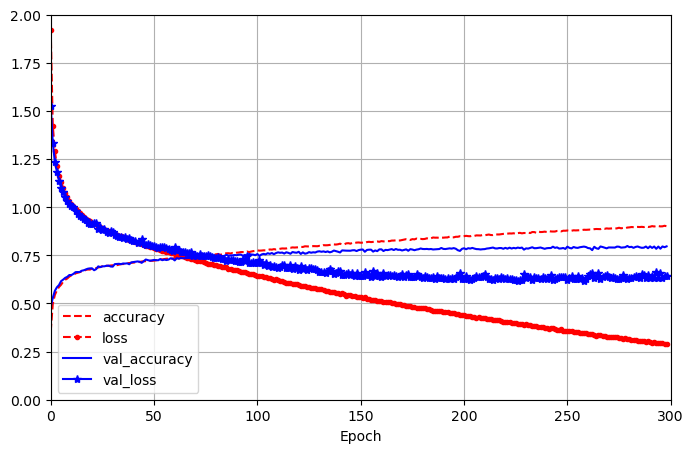

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model = Sequential([
    Flatten(input_shape=[57,]),
    Dense(300, activation='relu'),                                                                      
    Dense(300, activation='relu'),
    Dense(300, activation='relu'),
    Dense(10, activation='softmax')
])

early_stopping= EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=40) 
check_pointer = ModelCheckpoint(filepath = 'clf-resnet-checkpoint.keras',verbose=1,save_best_only=True) 
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    epochs=500, 
                    batch_size=64, 
                    verbose=1,
                    callbacks=[check_pointer,early_stopping])
best_model = tf.keras.models.load_model('clf-resnet-checkpoint.keras')

clear_output()
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 300], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

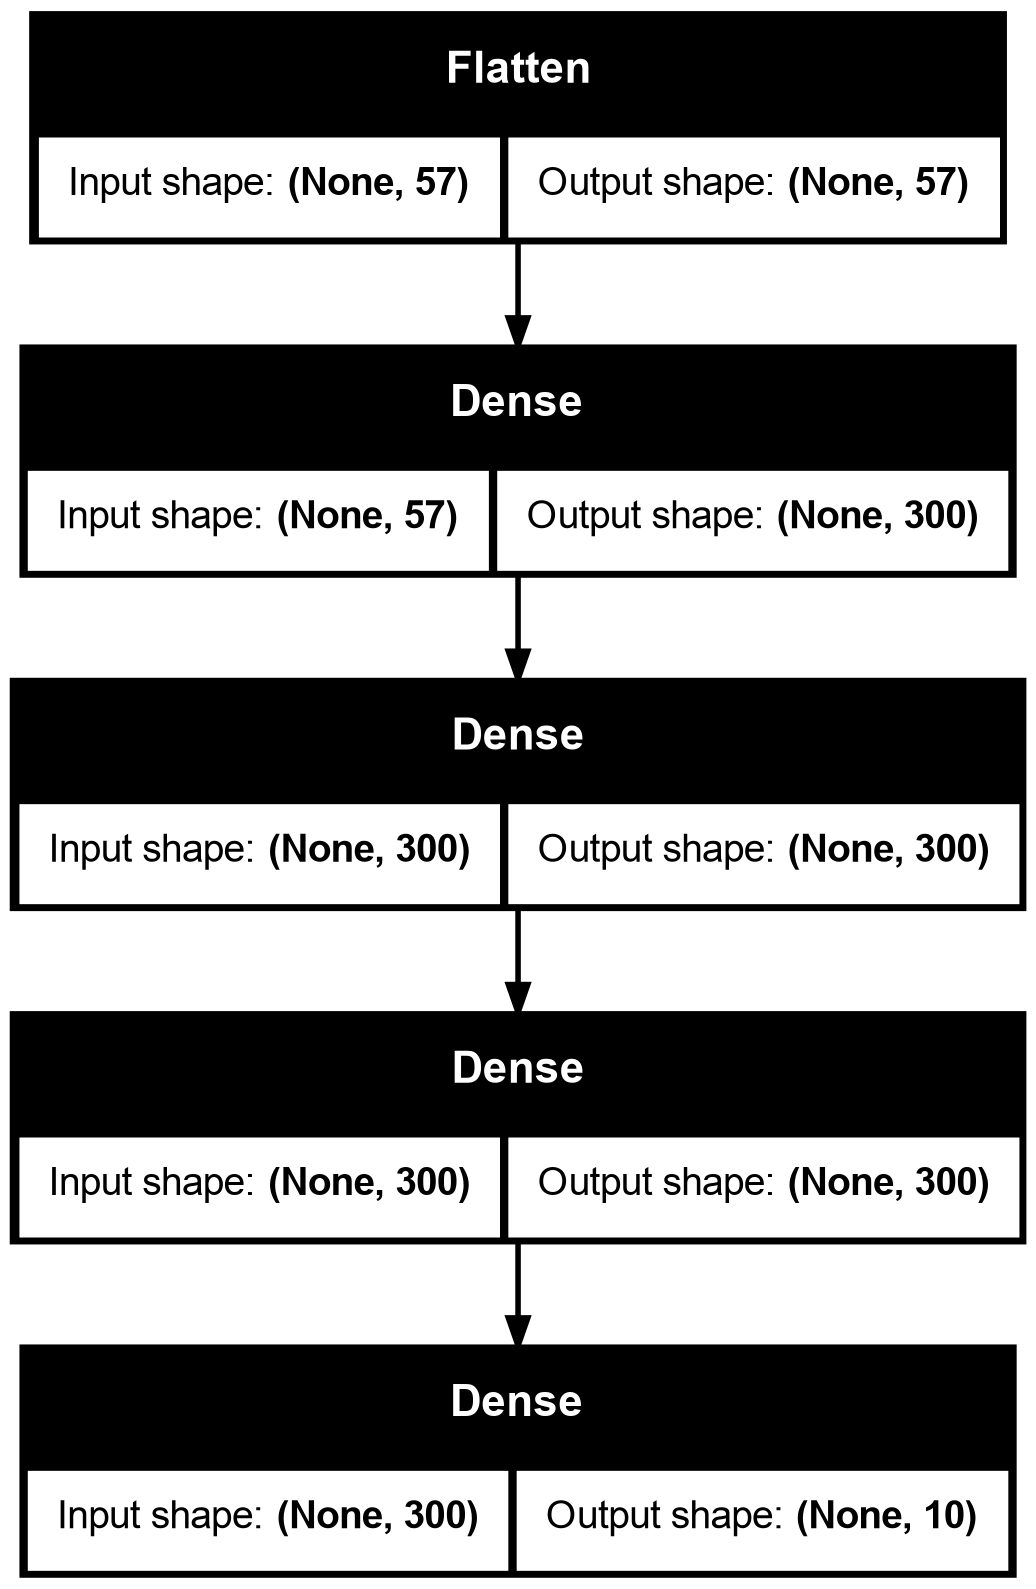

In [43]:
tf.keras.utils.plot_model(best_model, "my_model.png", show_shapes=True)

In [44]:
best_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 300)            │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,032 (2.30 MB)

 Trainable params: 201,010 (785.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,022 (1.53 MB)

# Evaluate the model

In [45]:
best_model.evaluate(X_test, y_test)

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.7872 - loss: 0.6644


[0.6693093776702881, 0.7864599227905273]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


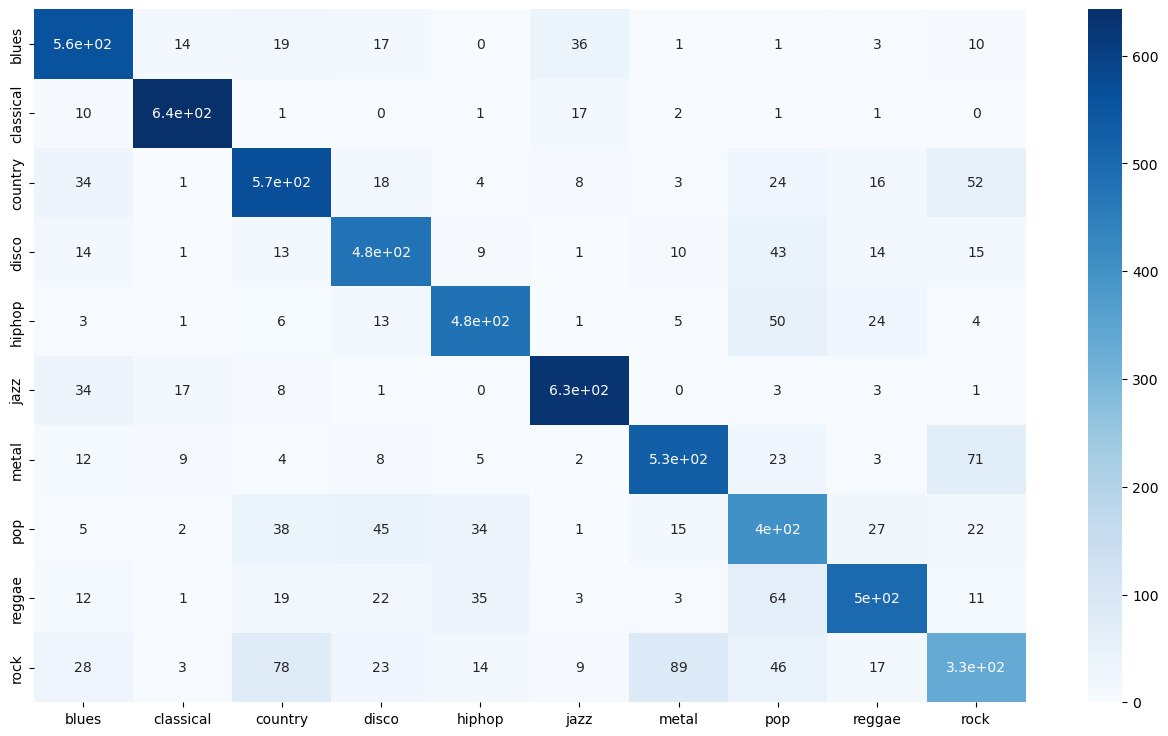

In [46]:
pred = np.argmax(best_model.predict(X_test),axis=-1)

confusion_matr = confusion_matrix(y_test, pred) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);

In [47]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       659
           1       0.93      0.95      0.94       676
           2       0.75      0.78      0.77       730
           3       0.76      0.80      0.78       598
           4       0.82      0.82      0.82       587
           5       0.89      0.90      0.90       698
           6       0.80      0.79      0.80       663
           7       0.61      0.68      0.65       593
           8       0.82      0.75      0.78       670
           9       0.64      0.52      0.57       640

    accuracy                           0.79      6514
   macro avg       0.78      0.78      0.78      6514
weighted avg       0.79      0.79      0.78      6514



In [49]:
import os
if os.path.exists('../saved_model/nn_model.keras'):
    os.remove('../saved_model/nn_model.keras')

best_model.save('../saved_model/nn_model.keras')